### Final Model IT2Tsk Gaussian

In [132]:

from notebook_resolver import *
from src.utils.pandas_extension import *
from src.dataset import Dataset, WorkSheet

dataset_path = "data/e-nose_dataset_12_beef_cuts.xlsx"
worksheet = WorkSheet.DS12.value

dataset = Dataset(
	path=dataset_path, sheet_name=worksheet,
)

train_df = dataset.train_df
test_df = dataset.test_df # <-- Test data only for final evaluation

In [133]:
from sklearn.metrics import r2_score
from src.pipeline import Pipeline
from src.pipelines.transformers import FeatureScaler
from src.pipelines.predictors import IT2TskPredictor
from src.fis.fuzzy_logic.mfs import MFType2
from src.clusters import ClusteringMethod
from src.fis.fuzzy_logic.consequents import LinearModel
from src.utils.hyperparameter import get_tuned_params

target_column = 'TVC'
tuned_params = get_tuned_params()[worksheet]
# tuned_params = {
# 	"batch_size": 256,
# 	"tol": 0.001,
# 	"max_no_improvement": 5,
# 	"uncertainty_factor": 0.07,
# 	"min_std_ratio": 0.06,
# }

pipeline = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	('predictor', IT2TskPredictor(target=target_column))
])

pipeline.fit(
    train_df, # pipeline fit only for training dataframe
    predictor__clustering_method=ClusteringMethod.MBKMEANS,
	predictor__mfs__cluster__batch_size=tuned_params.get("batch_size"),
	predictor__mfs__cluster__tol=tuned_params.get("tol"),
	predictor__mfs__cluster__max_no_improvement=tuned_params.get(
		"max_no_improvement"
	),  # Fixed for simplicity
	predictor__rules__cluster__batch_size=tuned_params.get("batch_size"),
	predictor__rules__cluster__tol=tuned_params.get("tol"),
	predictor__rules__cluster__max_no_improvement=tuned_params.get(
		"max_no_improvement"
	),  # Fixed for simplicity
	predictor__mf_type=MFType2.GAUSSIAN,
	predictor__linear_model=LinearModel.LSE,
	predictor__mf__builder__uncertainty_factor=tuned_params.get(
		"uncertainty_factor"
	),
	predictor__mf__builder__min_std_ratio=tuned_params.get(
		"min_std_ratio"
	),	
)

transformed_test_df = pipeline.transform(test_df)
X_test_df = transformed_test_df.drop(columns=[target_column])

y_test_ = transformed_test_df[target_column].values
y_pred_ = pipeline.predict(X_test_df)

r2 = r2_score(y_test_, y_pred_)
print(f"R2 Score on Test Data: {r2}")

R2 Score on Test Data: 0.9686795164855799


In [134]:
tuned_params

{'batch_size': 256,
 'tol': 0.001,
 'max_no_improvement': 5,
 'uncertainty_factor': 0.07,
 'min_std_ratio': 0.12}

In [135]:
predictor = pipeline.named_steps['predictor']

In [136]:
predictor.get_lt_rules()

+--------+-----------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Rule   | Cluster   | IF (Antecedents)                         | THEN (Consequents)                                                                                                                                                       |
+========+===========+==========================================+==========================================================================================================================================================================+
| Rule 1 | Cluster 0 | MQ135 is Low AND MQ136 is Low AND MQ137  | TVC is 0.8327 + 0.8656*MQ135 + -0.0486*MQ136 + -0.0513*MQ137 + 0.3142*MQ138 + 0.564*MQ2 + -2.0675*MQ3 + -0.6158*MQ4 + 0.0814*MQ5 + -0.0182*MQ6 + 0.0063*MQ8 + -0.002*MQ9 |
|        |           | is High AND MQ138 is Low AND 

,Rule,Cluster,IF (Antecedents),THEN (Consequents)
0,Rule 1,Cluster 0,MQ135 is Low AND MQ136 is Low AND MQ137 is Hig...,TVC is 0.8327 + 0.8656*MQ135 + -0.0486*MQ136 +...
1,Rule 2,Cluster 1,MQ135 is Low AND MQ136 is High AND MQ137 is Lo...,TVC is 0.2648 + 0.0082*MQ135 + -1.1076*MQ136 +...


In [137]:
predictor.clusters_.get_execution_time_stats('_create_mfs_clusters')

{'count': 1,
 'total_time': 2.5624144170433283,
 'average_time': 2.5624144170433283,
 'min_time': 2.5624144170433283,
 'max_time': 2.5624144170433283}

In [138]:
predictor.clusters_.get_execution_time_stats('_create_rules_cluster')

{'count': 1,
 'total_time': 0.21264883293770254,
 'average_time': 0.21264883293770254,
 'min_time': 0.21264883293770254,
 'max_time': 0.21264883293770254}

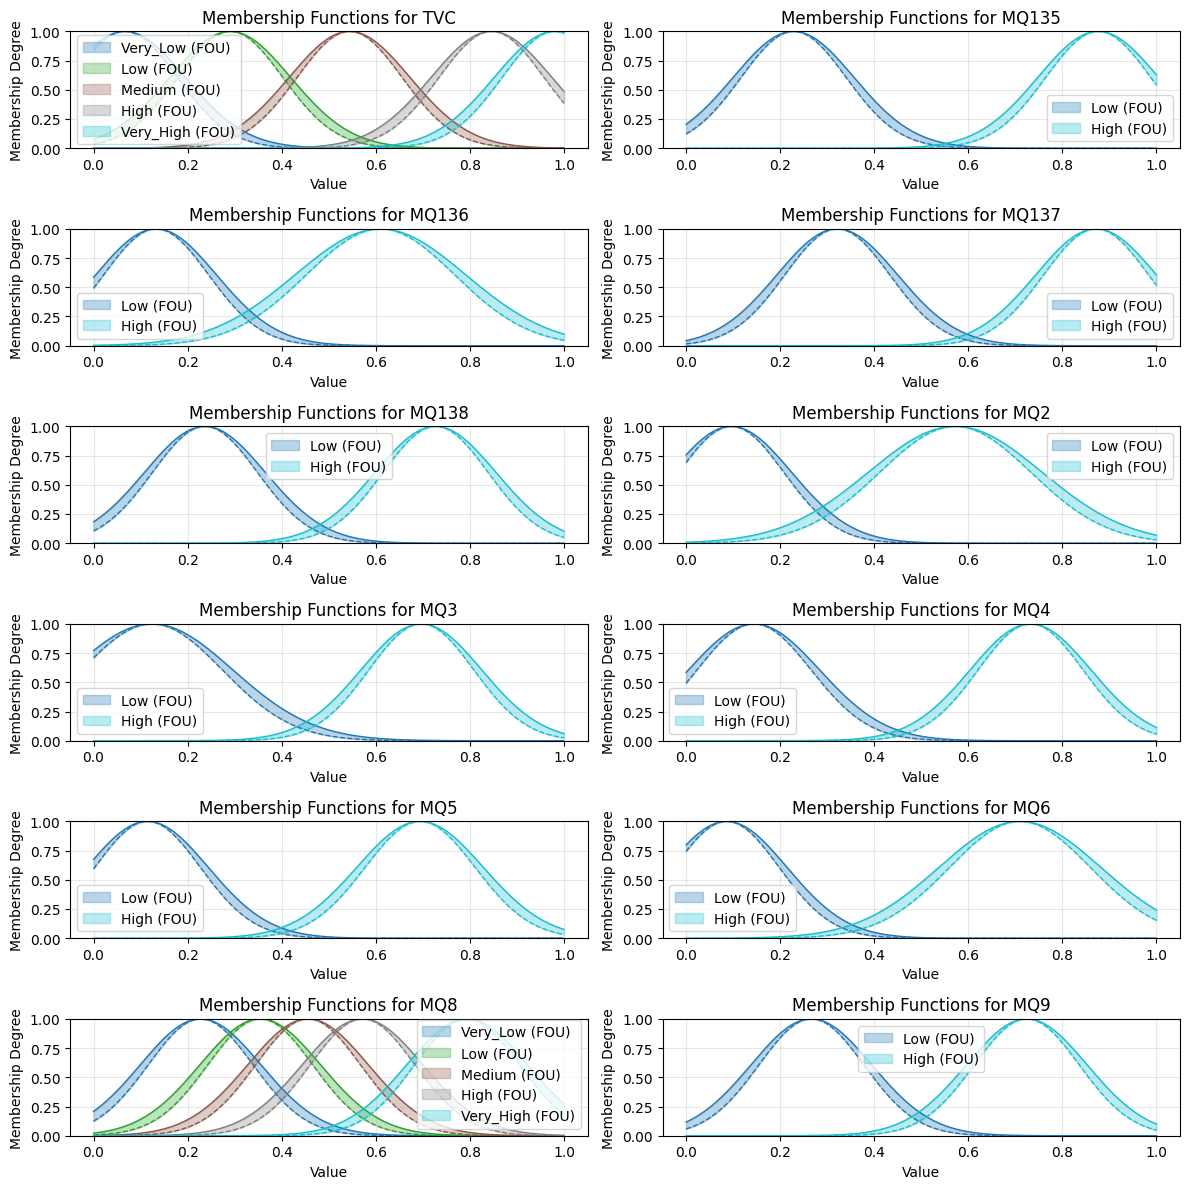

In [139]:
predictor.plot_mfs_grid()

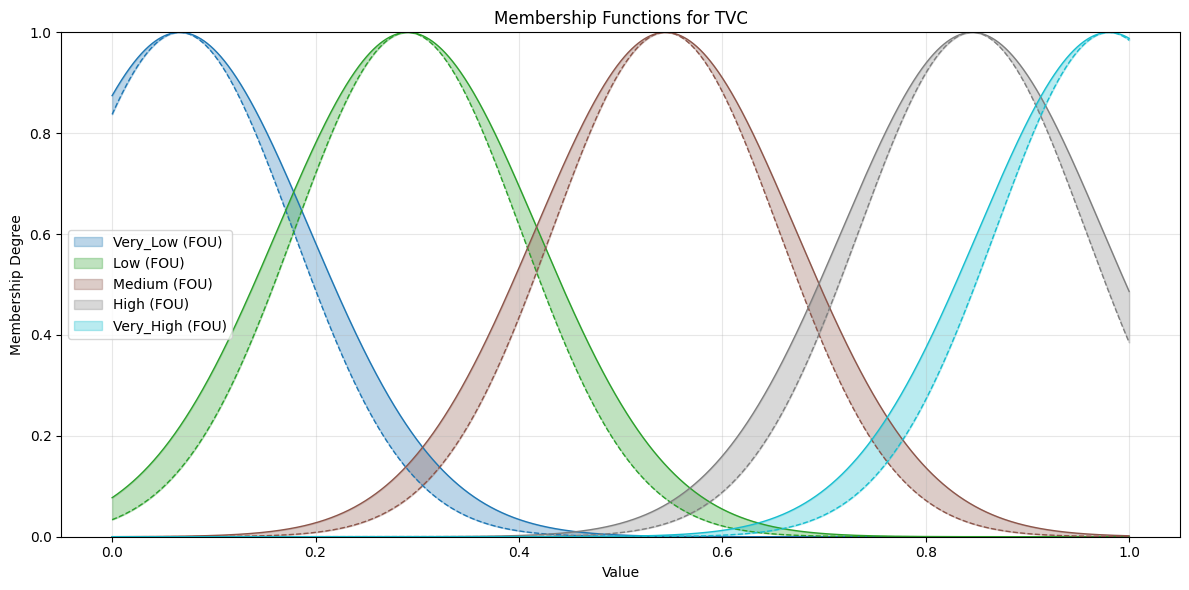

In [140]:
predictor.plot_mf('TVC')

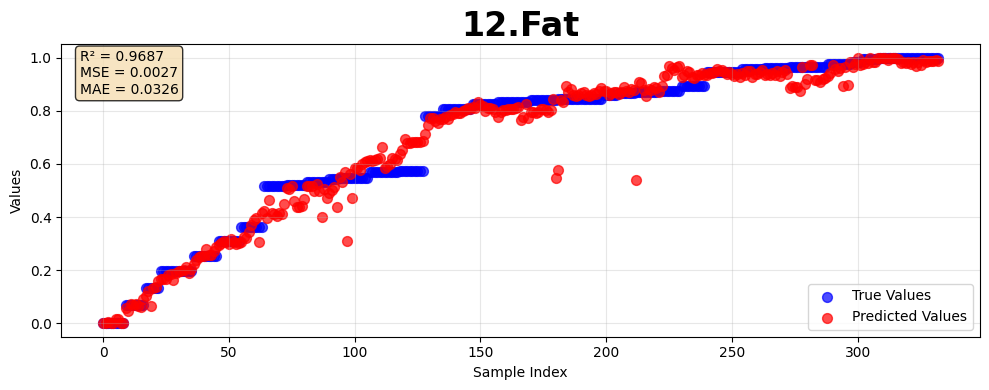

In [141]:
predictor.plot_true_vs_pred(y_true=y_test_, y_pred=y_pred_, title=f"{worksheet}")